In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import testCases #参见资料包，或者在文章底部copy
from dnn_utils import sigmoid, sigmoid_backward, relu, relu_backward #参见资料包
import lr_utils #参见资料包，或者在文章底部copy
np.random.seed(1)

真的是硬写，照着第三课的来，把对应的写成方法写成循环，然后执行哪里错改哪里

In [2]:
train_set_x_orig , train_set_y , test_set_x_orig , test_set_y , classes = lr_utils.load_dataset()

train_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T 
test_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

train_x = train_x_flatten / 255
train_y = train_set_y
test_x = test_x_flatten / 255
test_y = test_set_y

In [3]:
def init_parameters(L):
    '''
    l:layer列表 [4,2,1] 0位置为输入维度，1-最后位置为每层神经元个数
    '''
    
    np.random.seed(3)
    n_L = len(L)
    parameters = {}
    for i in range(1,n_L):
        parameters['W'+str(i)] = np.random.randn(L[i],L[i-1]) / np.sqrt(L[i - 1])
        parameters['b'+str(i)] = np.zeros((L[i],1))
    return parameters

In [4]:
def activation_forward(A_prev,W,b,activation):
    if activation == "relu":
        Z = np.dot(W,A_prev) + b
        A,activation_cache = relu(Z)
    elif activation == "sigmoid":
        Z = np.dot(W,A_prev) + b
        A,activation_cache = sigmoid(Z)
    return A,Z

In [5]:
def forward_propagation(X,parameters):
    
    L = len(parameters)//2
    
    A = X
    cache = {}
    for i in range(1,L):
        A_prev = A
        W = parameters['W'+str(i)]
        b = parameters['b'+str(i)]
        A,Z = activation_forward(A_prev,W,b,activation = "relu")
        cache['A'+str(i)] = A
        cache['Z'+str(i)] = Z
    
    
    A_prev = A
    W = parameters['W'+str(L)]
    b = parameters['b'+str(L)]
    A,Z = activation_forward(A_prev,W,b,activation = "sigmoid")
    cache['A'+str(L)] = A
    cache['Z'+str(L)] = Z
    
    cache['A0'] = X
    
    return cache

In [6]:
def compute_cost(A,Y):
    m = Y.shape[1]
    logprobs = - np.multiply(np.log(A), Y) - np.multiply((1 - Y), np.log(1 - A))
    cost = np.sum(logprobs)/m
    return cost

In [31]:
def activation_back(dA,A_prev,Z,W,b,activation):
    m = A_prev.shape[1]
    if activation == "relu":
        dZ = relu_backward(dA, Z)
        dW = np.dot(dZ,A_prev.T)/m
        db = np.sum(dZ,axis = 1,keepdims=True)/m
        dA_prev = np.dot(W.T,dZ)
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, Z)
        dW = np.dot(dZ,A_prev.T)/m
        db = np.sum(dZ,axis = 1,keepdims=True)/m
        dA_prev = np.dot(W.T,dZ)
    return dZ,dW,db,dA_prev

In [36]:
def back_propagation(X,Y,parameters,cache):
    grads = {}
    
    L = len(parameters)//2
    AL = cache['A' + str(L)]
    dA = - np.divide(Y, AL) + np.divide(1 - Y, 1 - AL)

    W = parameters['W' + str(L)]
    b = parameters['b' + str(L)]
    Z = cache['Z' + str(L)]
    A_prev = cache['A' + str(L-1)]
    

    dZ,dW,db,dA_prev = activation_back(dA,A_prev,Z,W,b,"sigmoid")
    grads["dZ" + str(L)] = dZ
    grads["dW" + str(L)] = dW
    grads["db" + str(L)] = db
    grads["dA" + str(L-1)] = dA_prev
    
    for i in reversed(range(1,L)):
        W = parameters['W' + str(i)]
        b = parameters['b' + str(i)]
        Z = cache['Z' + str(i)]
        A_prev = cache['A' + str(i-1)]
        dA = dA_prev
        dZ,dW,db,dA_prev = activation_back(dA,A_prev,Z,W,b,"relu")
        grads["dZ" + str(i)] = dZ
        grads["dW" + str(i)] = dW
        grads["db" + str(i)] = db
        grads["dA" + str(i-1)] = dA_prev
    return grads

In [9]:
def update_parameters(parameters,grads,learning_rate = 0.5):
    L = len(parameters)//2
    
    for i in range(1,L+1):
        parameters['W'+str(i)] -= grads['dW'+str(i)] * learning_rate
        parameters['b'+str(i)] -= grads['db'+str(i)] * learning_rate

    return parameters

In [44]:
def model(X,Y,L,num_iterations = 1000,learning_rate = 0.0075,print_cost = 0,isPlot =True):
    '''
    X : 训练集X
    Y : 训练集Y
    L : [layer0,layer1,layer2] 0层-最后一层神经元数量
    num_iterations : 训练次数
    learning_rate : 学习率
    print_cost : 多少次打印cost 0不打印
    '''
    
    np.random.seed(3)
    parameters = init_parameters(L)
    costLs = []
    for i in range(num_iterations):
        cache = forward_propagation(X,parameters)
        cost = compute_cost(cache['A'+str(len(L)-1)],Y)
        grads = back_propagation(X,Y,parameters,cache)
        parameters = update_parameters(parameters,grads,learning_rate)
        if print_cost > 0 and i %print_cost == 0:
            print(i,"--cost:",cost)
        if i % 10 == 0:
            costLs.append(cost)
    print("end --cost:",cost)
    
    if isPlot:
        plt.plot(np.squeeze(costLs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
    return parameters
        

In [226]:
def predict(X,parameters,threshold = 0.5):
    L = len(parameters)//2
    cache = forward_propagation(X,parameters)
    AL = cache['A'+str(L)]
    for i,v in enumerate(AL[0,:]):
        if v >= threshold :
            AL[0,i] = 1
        else:
            AL[0,i] = 0
    return AL

0 --cost: 0.715731513413713
100 --cost: 0.6747377593469114
200 --cost: 0.6603365433622127
300 --cost: 0.6462887802148751
400 --cost: 0.6298131216927773
500 --cost: 0.6060056229265339
600 --cost: 0.5690041263975135
700 --cost: 0.5197965350438059
800 --cost: 0.46415716786282285
900 --cost: 0.40842030048298916
1000 --cost: 0.37315499216069037
1100 --cost: 0.3057237457304711
1200 --cost: 0.2681015284774084
1300 --cost: 0.23872474827672602
1400 --cost: 0.20632263257914712
1500 --cost: 0.17943886927493552
1600 --cost: 0.15798735818801263
1700 --cost: 0.14240413012274003
1800 --cost: 0.12865165997886205
1900 --cost: 0.11244314998156636
2000 --cost: 0.08505631034968726
2100 --cost: 0.05758391198607193
2200 --cost: 0.04456753454694545
2300 --cost: 0.03808275166598005
2400 --cost: 0.034410749018405254


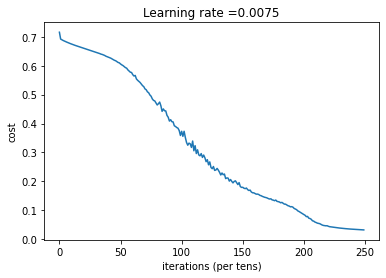

end --cost: 0.031766492301035884


In [45]:
layers_dims = [12288,20, 7, 5, 1] #  4-layer model
parameters = model(train_x, train_y, layers_dims, num_iterations = 2500, print_cost = 100)

In [53]:
pred_train_y = predict(train_x, parameters) #训练集
pred_test_y = predict(test_x, parameters) #测试集

In [54]:
print("train_acc:",np.sum(pred_train_y == train_y)/train_y.shape[1])
print("test_acc:",np.sum(pred_test_y == test_y)/test_y.shape[1])

train_acc: 0.9952153110047847
test_acc: 0.78


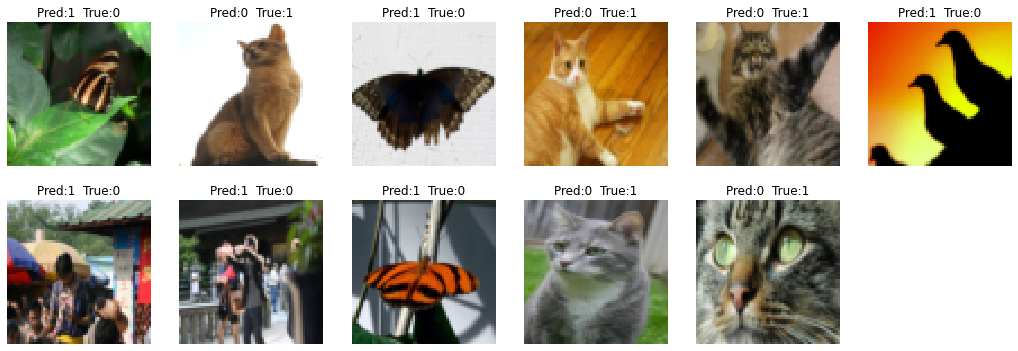

In [131]:
miss_index = np.asarray(np.where(pred_test_y != test_y))[1]
num_imgs = len(miss_index)
plt.figure(figsize=(18,6))
for i in range(num_imgs):
    plt.subplot(2,num_imgs//2+1,i+1)
    plt.imshow(test_x[:,miss_index[i]].reshape(64,64,3), interpolation='nearest')
    plt.axis('off')
    plt.title("Pred:"+ str(int(pred_test_y[0,miss_index[i]])) +"  True:" + str(int(test_y[0,miss_index[i]])))

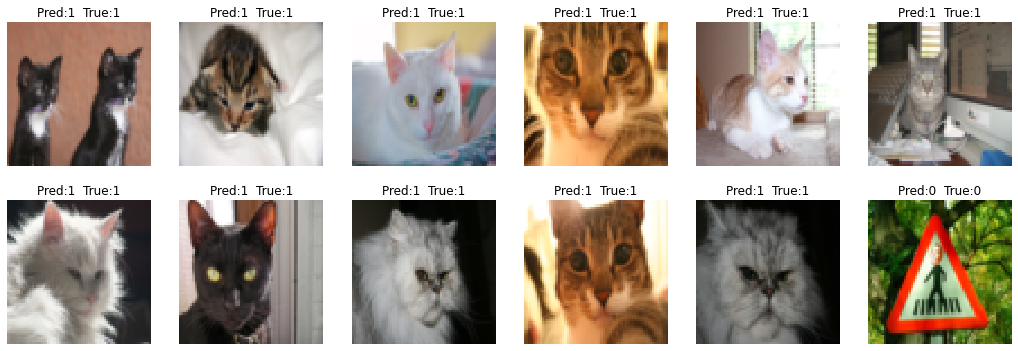

In [133]:
miss_index = np.asarray(np.where(pred_test_y == test_y))[1]
num_imgs = len(miss_index)
plt.figure(figsize=(18,6))
for i in range(12):
    plt.subplot(2,6,i+1)
    plt.imshow(test_x[:,miss_index[i]].reshape(64,64,3), interpolation='nearest')
    plt.axis('off')
    plt.title("Pred:"+ str(int(pred_test_y[0,miss_index[i]])) +"  True:" + str(int(test_y[0,miss_index[i]])))

In [201]:
from PIL import Image
img = Image.open("cat.png")
img = img.convert("RGB")
im_arr = np.array(img.resize((64,64)))
img_flatten = im_arr.reshape(64*64*3,1)/255

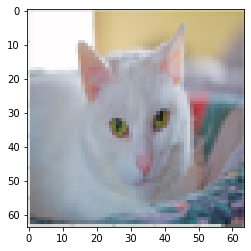

In [228]:
plt.imshow(im_arr, interpolation='nearest')

In [227]:
predict(img_flatten,parameters)

array([[1.]])